# NLP Assignment -  Identifying Entities in Healthcare Data

### Project Outcome: Suggest treatments to the diseases



#### Student Name: <font color="green">Sameer Gadicherla</font>
#### Batch: <font color="green">March 31' 2021</font>

## 1. Import and Install useful packages.

In [194]:
!pip3 install pycrf
!pip3 install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd

model = spacy.load("en_core_web_sm")

You should consider upgrading via the '/Applications/Anaconda/anaconda3/envs/mindmeld_3813/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Applications/Anaconda/anaconda3/envs/mindmeld_3813/bin/python -m pip install --upgrade pip' command.


## 2. Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

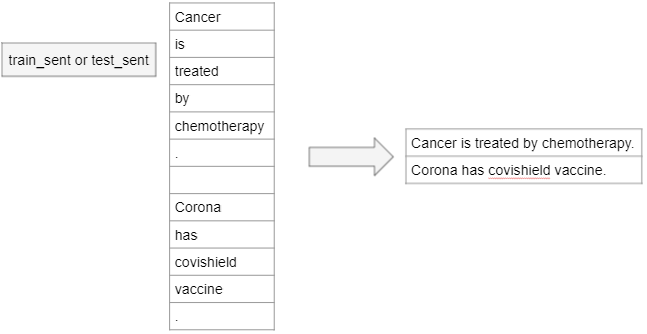

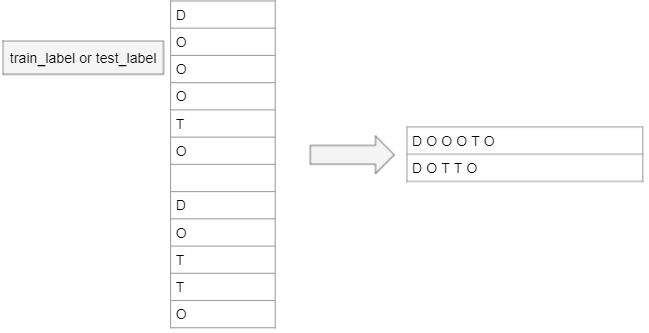

In [197]:
all_words = []


def sentenceFormatter(path):
    sent = open(path,"r")  ##open the datafile
    sent = sent.read()  ##read the whole file as string
    sentences = sent.split("\n\n") ##split the string using two newlines to separate out the sentences
    all_sentences = []
    for sentence in sentences:
        all_sentences.append(" ".join(sentence.split("\n"))) ##form a new sentence by splitting on \n and joining with space
        all_words.extend(sentence.split("\n")) ##append all these words to a global word list
    return all_sentences

##getting all train sentences
all_train_sentences = sentenceFormatter("train_sent")

##getting all train labelled sentences
all_train_label_sentences = sentenceFormatter("train_label")

##getting all test sentences
all_test_sentences = sentenceFormatter("test_sent")

##getting all test labelled sentences
all_test_label_sentences = sentenceFormatter("test_label")

In [200]:
##Lets print random five sentences
for sent in all_train_sentences[1004:1009]:
    print(sent)
    print("-"*100)

print("\n"*2)    

# Lets print random five labels
for labels_sent in all_train_label_sentences[1004:1009]:
    print(labels_sent)
    print("-"*100)

The rationale of extended resection for complicated cancer of the large bowel
----------------------------------------------------------------------------------------------------
Surgical treatment of urinary stones
----------------------------------------------------------------------------------------------------
Prevention of stone formation
----------------------------------------------------------------------------------------------------
Urinary calculi
----------------------------------------------------------------------------------------------------
The family medicine program of the University of Miami
----------------------------------------------------------------------------------------------------



O O O T T O D D D D D D
----------------------------------------------------------------------------------------------------
T T O D D
----------------------------------------------------------------------------------------------------
O O D D
--------------------------------

#### Lets look at the total number of words

In [199]:
print(len(all_words))

129044


#### Count the number of sentences in the processed train and test dataset 

In [203]:
print("Sentence Samples in train data: ", len(all_train_sentences))
print("Sentence Samples in test data: ", len(all_test_sentences))

Sentence Samples in train data:  2600
Sentence Samples in test data:  1057


#### Count the number of lines of labels in the processed train and test dataset.

In [202]:
print("Sentence labels in train data: ", len(all_train_label_sentences))
print("Sentence labels in test data: ", len(all_test_label_sentences))

Sentence labels in train data:  2600
Sentence labels in test data:  1057


## 3.Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



#### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [204]:
model1 = spacy.load("en_core_web_sm",disable=['parser','ner']) ##load the ner model lightly just for POS tagging
all_noun_pron_tokens = {} ##a hashmap of noun/propn to its count
dataset = [all_train_sentences,all_test_sentences] ##iterate over train and test set
for split in dataset: ##for each of train and test dataset
    for sent in split:
        processed_nlp = model1(sent) ## process each sentence
        for token in processed_nlp:
            if token.pos_ == 'NOUN' or token.pos_ == 'PROPN': ##check if each token is a NOUN or PROPN
                try:
                    all_noun_pron_tokens[token.text.lower()]+=1 ##increment counts
                except:
                    all_noun_pron_tokens[token.text.lower()] = 1

#### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [205]:
#Create a dataframe with the counts of NOUNs and PROPNs
noun_propn_df = pd.DataFrame({
    "noun/propn":list(all_noun_pron_tokens.keys()),
    "occurences":list(all_noun_pron_tokens.values())
            }).sort_values(by='occurences', ascending=False)
noun_propn_df.iloc[0:25,:]

,noun/propn,occurences
19,patients,507
66,treatment,304
16,%,247
287,cancer,211
427,therapy,177
58,study,175
221,disease,150
1140,cell,142
1781,lung,118
258,results,117


### We see that there are words like **chemotherapy,patients,treatment,cancer,therapy,surgery...**

## 4.Defining features for CRF





- Usually in medical terms like disease and treatment names, we see that most of the times they are multiword terms.
- We can see if they are lengthy than normal words.
- We can check the last two or three words as they might end with words like 'apy'(chemortherapy etc..)
- We can check if the word is all caps or a title with mixed letter casing
- We can see if the word has a number and characters combination like **achondrogensis 1B** is a disease
- Similarly we can check if they have hyphens,/,brackets and paranthesis
- Check if the word is NOUN or PROPN
- Few similar characterisitcs can be checked with the previous word as well

#### Features referred from a good research - http://ceur-ws.org/Vol-1650/smbm16Hahn.pdf

## Getting the features

In [206]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos, proc_sent):
    word = sentence[pos]
    pos_tag = proc_sent[pos].pos_
    features = [
    'word.isNoun=' + str(pos_tag=='NOUN'),
    'word.isPropn=' + str(pos_tag=='PROPN'),
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.lower=' + word.lower(), # serves as word id
    'word.isTitle=' + str(word[0].isupper()),     # is Title
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.ismixed=' + str((not word.islower() and not word.isupper())),
    'word.hasNumandAlph='+str(word.isalnum() and not word.isalpha() and not word.isdigit()),
    'word.hasParan='+ str('(' in word and ')' in word),
    'word.hasBracks='+ str('[' in word and ']' in word),
    'word.hasSlash='+ str('/' in word),
    'word.hashyphen='+ str('-' in word),
    'word.isLonger='+ str(len(word)>=10),
    'word.twoHyphens='+str(word.count('-')==2),
    'word.isdigit=%s' % word.isdigit()
  ]
    
    if(pos > 0):
        prev_word = sentence[pos-1]
        prev_pos_tag = proc_sent[pos-1].pos_
        features.extend([
        'prev_word.isNoun=' + str(prev_pos_tag=='NOUN'),
        'prev_word.isPropn=' + str(pos_tag=='PROPN'),
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
         'prev_word.isdigit=%s' % prev_word.isdigit(),   
        'prev_words.isTitle=%s' % prev_word[0].isupper(),
      ])
    else:
        features.append('BEG') # feature to track begin of sentence 
    
    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence
    
    return features

### Write a code/function to get the features for a sentence

In [207]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    proc_sent = model(sentence)
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, proc_sent) for pos in range(len(sentence_list))]

In [239]:
## lets print features of one random sentence which is a list of features of words
getFeaturesForOneSentence(all_train_label_sentences[386])

[['word.isNoun=False',
  'word.isPropn=False',
  'word[-3:]=O',
  'word[-2:]=O',
  'word.lower=o',
  'word.isTitle=True',
  'word.isupper=True',
  'word.ismixed=False',
  'word.hasNumandAlph=False',
  'word.hasParan=False',
  'word.hasBracks=False',
  'word.hasSlash=False',
  'word.hashyphen=False',
  'word.isLonger=False',
  'word.twoHyphens=False',
  'word.isdigit=False',
  'BEG'],
 ['word.isNoun=True',
  'word.isPropn=False',
  'word[-3:]=O',
  'word[-2:]=O',
  'word.lower=o',
  'word.isTitle=True',
  'word.isupper=True',
  'word.ismixed=False',
  'word.hasNumandAlph=False',
  'word.hasParan=False',
  'word.hasBracks=False',
  'word.hasSlash=False',
  'word.hashyphen=False',
  'word.isLonger=False',
  'word.twoHyphens=False',
  'word.isdigit=False',
  'prev_word.isNoun=False',
  'prev_word.isPropn=False',
  'prev_word.lower=o',
  'prev_word.isupper=True',
  'prev_word.isdigit=False',
  'prev_words.isTitle=True'],
 ['word.isNoun=True',
  'word.isPropn=False',
  'word[-3:]=O',
  'word

### Write a code/function to get the labels of a sentence

In [208]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [238]:
## let's get the labels of one random sentence
getLabelsInListForOneSentence(all_train_label_sentences[386])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D']

## 5. Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [209]:
X_train = [getFeaturesForOneSentence(sent) for sent in all_train_sentences] ##list of sentence features in train
X_test = [getFeaturesForOneSentence(sent) for sent in all_test_sentences] ##list of sentence features in test

### Define the labels as the target variable for test and the train dataset

In [210]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in all_train_label_sentences] ##list of sentence labels in train
Y_test = [getLabelsInListForOneSentence(labels) for labels in all_test_label_sentences] ##list of sentence labels in test

## 6. Build the CRF Model

In [211]:
# Build the CRF model with more iterations as it doesnt take much time
crf = sklearn_crfsuite.CRF(max_iterations=500)
crf.fit(X_train,Y_train)

CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
  averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
  calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=500,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

## 7. Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [214]:
Y_pred = crf.predict(X_test) ##getting the predictions over the test set

##testing prediction on a random sentence in test set
print(all_test_sentences[46],"\n\n")
print("predicted:\n",Y_pred[46])
print("actual:\n",Y_test[46])


< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy 


predicted:
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'T']
actual:
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


We can see that though the actual test value has been wrongly given that **hereditary retinoblastoma** isn't a disease and **radiotherapy** isn't its treatment, our model was intelligent enough to capture that as well

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [184]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9146061478789398

We see that we got a **91.46% (0.9146)** F1 Score which is pretty strong learner!

## 8.Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

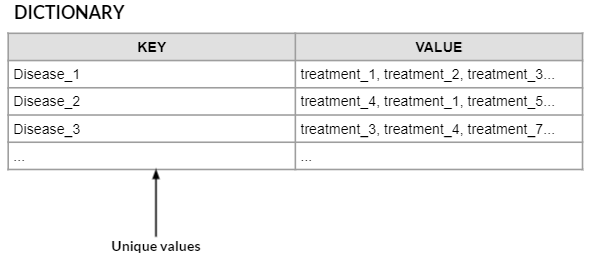

Because we have disease names with more than one word like **small cell lung cancer** and also its treatment being like **prophylactic cranial irradiation** , we need to create proper disease names and their respective treatment names

In [217]:
## creating a disctionary of disease:[treatment1,....]
disease_to_treatment = {}
for sent_pred_idx in range(len(Y_pred)): ##for each sentence in the predicted labels over test data
    disease_list = []
    treatment_list = []
    label_pred_idx = 0
    while label_pred_idx < len(Y_pred[sent_pred_idx]):
        
        ##Once we find the start of a disease name, till we keep getting value D , create a disease name combined
        if Y_pred[sent_pred_idx][label_pred_idx] == 'D':
            disease_name = ""
            while label_pred_idx < len(Y_pred[sent_pred_idx]) and Y_pred[sent_pred_idx][label_pred_idx] == 'D':
                disease_name+=all_test_sentences[sent_pred_idx].split(' ')[label_pred_idx] + " "
                label_pred_idx+=1
                
            ##append the disease name to the disease list    
            disease_list.append(disease_name[:-1])
        
        ##Once we find the start of a treatment name, till we keep getting value T , create a treatment name combined
        elif Y_pred[sent_pred_idx][label_pred_idx] == 'T':
            treatment_name = ""
            while label_pred_idx < len(Y_pred[sent_pred_idx]) and Y_pred[sent_pred_idx][label_pred_idx] == 'T':
                treatment_name+=all_test_sentences[sent_pred_idx].split(' ')[label_pred_idx] + " "
                label_pred_idx+=1
            
            ##append the treatment name to treatment list
            treatment_list.append(treatment_name[:-1])
            
        ##ignore other labels
        else:
            label_pred_idx+=1
    
    ## process the disease and treatment list where ith value in treatment_list are all the treatments possible-
    ## -for all the diseases at the ith index for each sentence. Let's add them to the disease:[treatment1,..] format
    
    if treatment_list != []: ##add only if disease in the sentence has a treatment in the same sentence
        for disease in disease_list: ##for each disease , all the treatments should be added
            for treatment in treatment_list: ##add each treatment for the same disease

                ##if disease key exists
                if disease.lower() in disease_to_treatment.keys() and treatment.lower() not in disease_to_treatment[disease.lower()]:
                    disease_to_treatment[disease.lower()].append(treatment.lower())

                ##else create the disease key
                else: 
                    disease_to_treatment[disease.lower()] = [treatment.lower()]
disease_to_treatment
        

{'hereditary retinoblastoma': ['radiotherapy'],
 'unstable angina or non-q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['antichlamydial antibiotics'],
 'primary pulmonary hypertension ( pph )': ['fenfluramines'],
 'essential hypertension': ['moxonidine'],
 'cellulitis': ['g-csf therapy', 'intravenous antibiotic treatment'],
 'cardiac disease': ['fenfluramine-phentermine'],
 "early parkinson 's disease": ['ropinirole monotherapy'],
 'sore throat': ['antibiotics'],
 'abdominal tuberculosis': ['steroids'],
 'female stress urinary incontinence': ['surgical treatment'],
 'stress urinary incontinence': ['therapy'],
 'preeclampsia ( proteinuric hypertension': ['intrauterine insemination with donor sperm versus intrauterine insemination'],
 'severe acquired hyperammonemia': ['organ transplantation and chemotherapy'],
 'cancer': ['organ transplantation and chemotherapy',
  'chemotherapy',
  'matrix metalloproteinase inhibitors'],
 'major pulmonary embolism': ['th

In [222]:
##display the table of disease to treatment list as a table using dataframe
pd.set_option('display.max_rows', None)
disease_to_treatment_df = pd.DataFrame({"disease_name":disease_to_treatment.keys(),"treatments":disease_to_treatment.values()})
disease_to_treatment_df

,disease_name,treatments
0,hereditary retinoblastoma,[radiotherapy]
1,unstable angina or non-q-wave myocardial infar...,[roxithromycin]
2,coronary-artery disease,[antichlamydial antibiotics]
3,primary pulmonary hypertension ( pph ),[fenfluramines]
4,essential hypertension,[moxonidine]
5,cellulitis,"[g-csf therapy, intravenous antibiotic treatment]"
6,cardiac disease,[fenfluramine-phentermine]
7,early parkinson 's disease,[ropinirole monotherapy]
8,sore throat,[antibiotics]
9,abdominal tuberculosis,[steroids]


##  9.Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [223]:
disease_to_treatment["hereditary retinoblastoma"]

['radiotherapy']

In [225]:
##check if that radiotherapy is the right treatment in the sentence of medical data
for sent in all_test_sentences:
    if "hereditary retinoblastoma" in sent.lower():
        print(sent)

< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy


### We can see that our CRF model could predict ***radiotherapy*** as the treatment for ***hereditary retinoblastoma*** !!!!